# Australian Boreholes

Looking at the data from the [**Australian Borehole Stratigraphic Unit Compilation**](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/147641) 2023 v1.0

In [33]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import pygmt
from joblib import Parallel, delayed

In [35]:
absuc = pd.read_csv("../data/ABSUC/ABSUC_v1_BASE.txt")  # preferred stratigraphic picks for the base of each unit
absuc.set_index("GA_GUID", inplace=True)
# remove entries with NaNs in the seemingly relevant depth measurements
absuc.dropna(
    axis=0,
    subset=("TD_MD_M", "TOP_MD_M", "BASE_MD_M", "TOP_AHD_M", "BASE_AHD_M"),
    inplace=True,
)

# remove some irrelevant columns
absuc.drop(
    labels=[
        "OBJECTID",
        "GA_ENO",
        "UWI",
        "GL_AHD_M",
        "WD_AHD_M",
        "SRTM_HE_AHD_M",
        "DATUM_ELEVATION_AHD_M",
        "DATA_SOURCE",
        "GA_HYDROSTRAT",
        "TAG",
        "Z_M_SRTM",
        "COMMENT",
    ],
    axis=1,
    inplace=True
)

absuc.shape


/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_60053/3004378177.py:1: DtypeWarning: Columns (4,28) have mixed types. Specify dtype option on import or set low_memory=False.
  absuc = pd.read_csv("../data/ABSUC/ABSUC_v1_BASE.txt")  # preferred stratigraphic picks for the base of each unit


(379493, 16)

In [37]:
def get_unique_borehole(_id):
    """
    Get unique boreholes.  Select perferred source (HIERARCHY=min)
    Returns indices that need to be dropped
    """
    subset = absuc[absuc["GA_BOREHOLE_GUID"] == _id]
    best = np.min(subset["HIERARCHY"].unique())
    return subset[subset["HIERARCHY"] != best].index

ids = absuc["GA_BOREHOLE_GUID"].unique()
#THIS IS REALLY SLOW FOR SOME REASON
# r = Parallel(n_jobs=-1)(delayed(get_unique_borehole)(_id) for _id in ids)

In [28]:
absuc[absuc["GA_BOREHOLE_GUID"] == "{412fc35f-d103-4b74-8ff7-751dbc86e18c}"]

,GA_BOREHOLE_GUID,BOREHOLE_NAME,GDA94_LATITUDE,GDA94_LONGITUDE,DATUM_NAME,TD_MD_M,SOURCE_UNIT,GA_UNIT,GA_ASUD_NO,TOP_MD_M,BASE_MD_M,TOP_AHD_M,BASE_AHD_M,Z_AHD_M,HIERARCHY,PREFERRED
GA_GUID,,,,,,,,,,,,,,,,
{5407c45e-d4f0-4e83-ae24-6d069d8a0ae7},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Nappamerri Group,Nappamerri Group,13823.0,1901.342,2093.671,-1822.128,-2014.457,-2014.457,250,TB
{2b10e708-640e-4719-9060-b84cb391461f},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Toolachee Formation,Toolachee Formation,18357.0,2093.671,2220.468,-2014.457,-2141.254,-2141.254,250,TB
{c7b67079-9801-4428-8d8c-e0559651bd3f},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Daralingie Formation,Daralingie Formation,5198.0,2220.468,2229.917,-2141.254,-2150.703,-2150.703,250,TB
{2c884fa6-9ec5-4402-bb2f-011c3c0d1681},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Roseneath Shale,Roseneath Shale,16348.0,2229.917,2297.582,-2150.703,-2218.368,-2218.368,250,TB
{7fe5566a-391b-4477-a21c-c303fca51f23},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Epsilon Formation,Epsilon Formation,6221.0,2297.582,2351.227,-2218.368,-2272.013,-2272.013,250,TB
{6ea43f00-c561-485d-9664-f31c63917a12},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Murteree Shale,Murteree Shale,13586.0,2351.227,2406.091,-2272.013,-2326.877,-2326.877,250,TB
{2a419bd4-e594-4d80-81aa-4c775453b526},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Patchawarra Formation,Patchawarra Formation,14936.0,2406.091,2718.820,-2326.877,-2639.606,-2639.606,250,TB
{d82780d8-ade9-4852-acd7-c457d75aeb2e},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Tirrawarra Sandstone/ Merrimelia Formation,Gidgealpa Group,7182.0,2718.820,2740.762,-2639.606,-2661.548,-2661.548,250,TB


In [27]:
ids = absuc["GA_BOREHOLE_GUID"].unique()[0]
subset = absuc[absuc["GA_BOREHOLE_GUID"] == ids]
best = np.min(subset["HIERARCHY"].unique())
absuc.drop(subset[subset["HIERARCHY"] != best].index, axis=0, inplace=True)

Try a couple boreholes in SA and see if we can estimate something similar to what is given on SARIG

In [78]:
import requests
import zipfile
import io
import os

In [91]:
datadir = os.path.join("..", "data", "SA_drillholes")
if not os.path.exists(datadir):
    print("downloading...")
    r = requests.get("https://data.sarig.sa.gov.au/Map/Download/layerDownload?layeId=924&formatLovId=20")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=datadir)
    with open(os.path.join(datadir, ".gitignore"), "w") as f:
        f.write("*")
SA = gpd.read_file(os.path.join(datadir, "drillholes_depthtobasement.shp"))
SA.columns

downloading...


Index(['GDA94_X', 'STRATDESC', 'STRAT_NAME', 'COVR_THICK', 'MAXAGE', 'MINAGE',
       'MAPUNIT', 'ELEVATION', 'BASEMNT_RL', 'ADJLCC_Y', 'ADJLCC_X', 'LCC_Y01',
       'LCC_X02', 'ADJGDA94_Y', 'ADJGDA94_X', 'GDA94_Y03', 'ADJ_ELEV',
       'MAX_DEPTH', 'TO_DEPTH', 'FROM_DEPTH', 'DHNUMBER', 'DH_NAME',
       'geometry'],
      dtype='object')

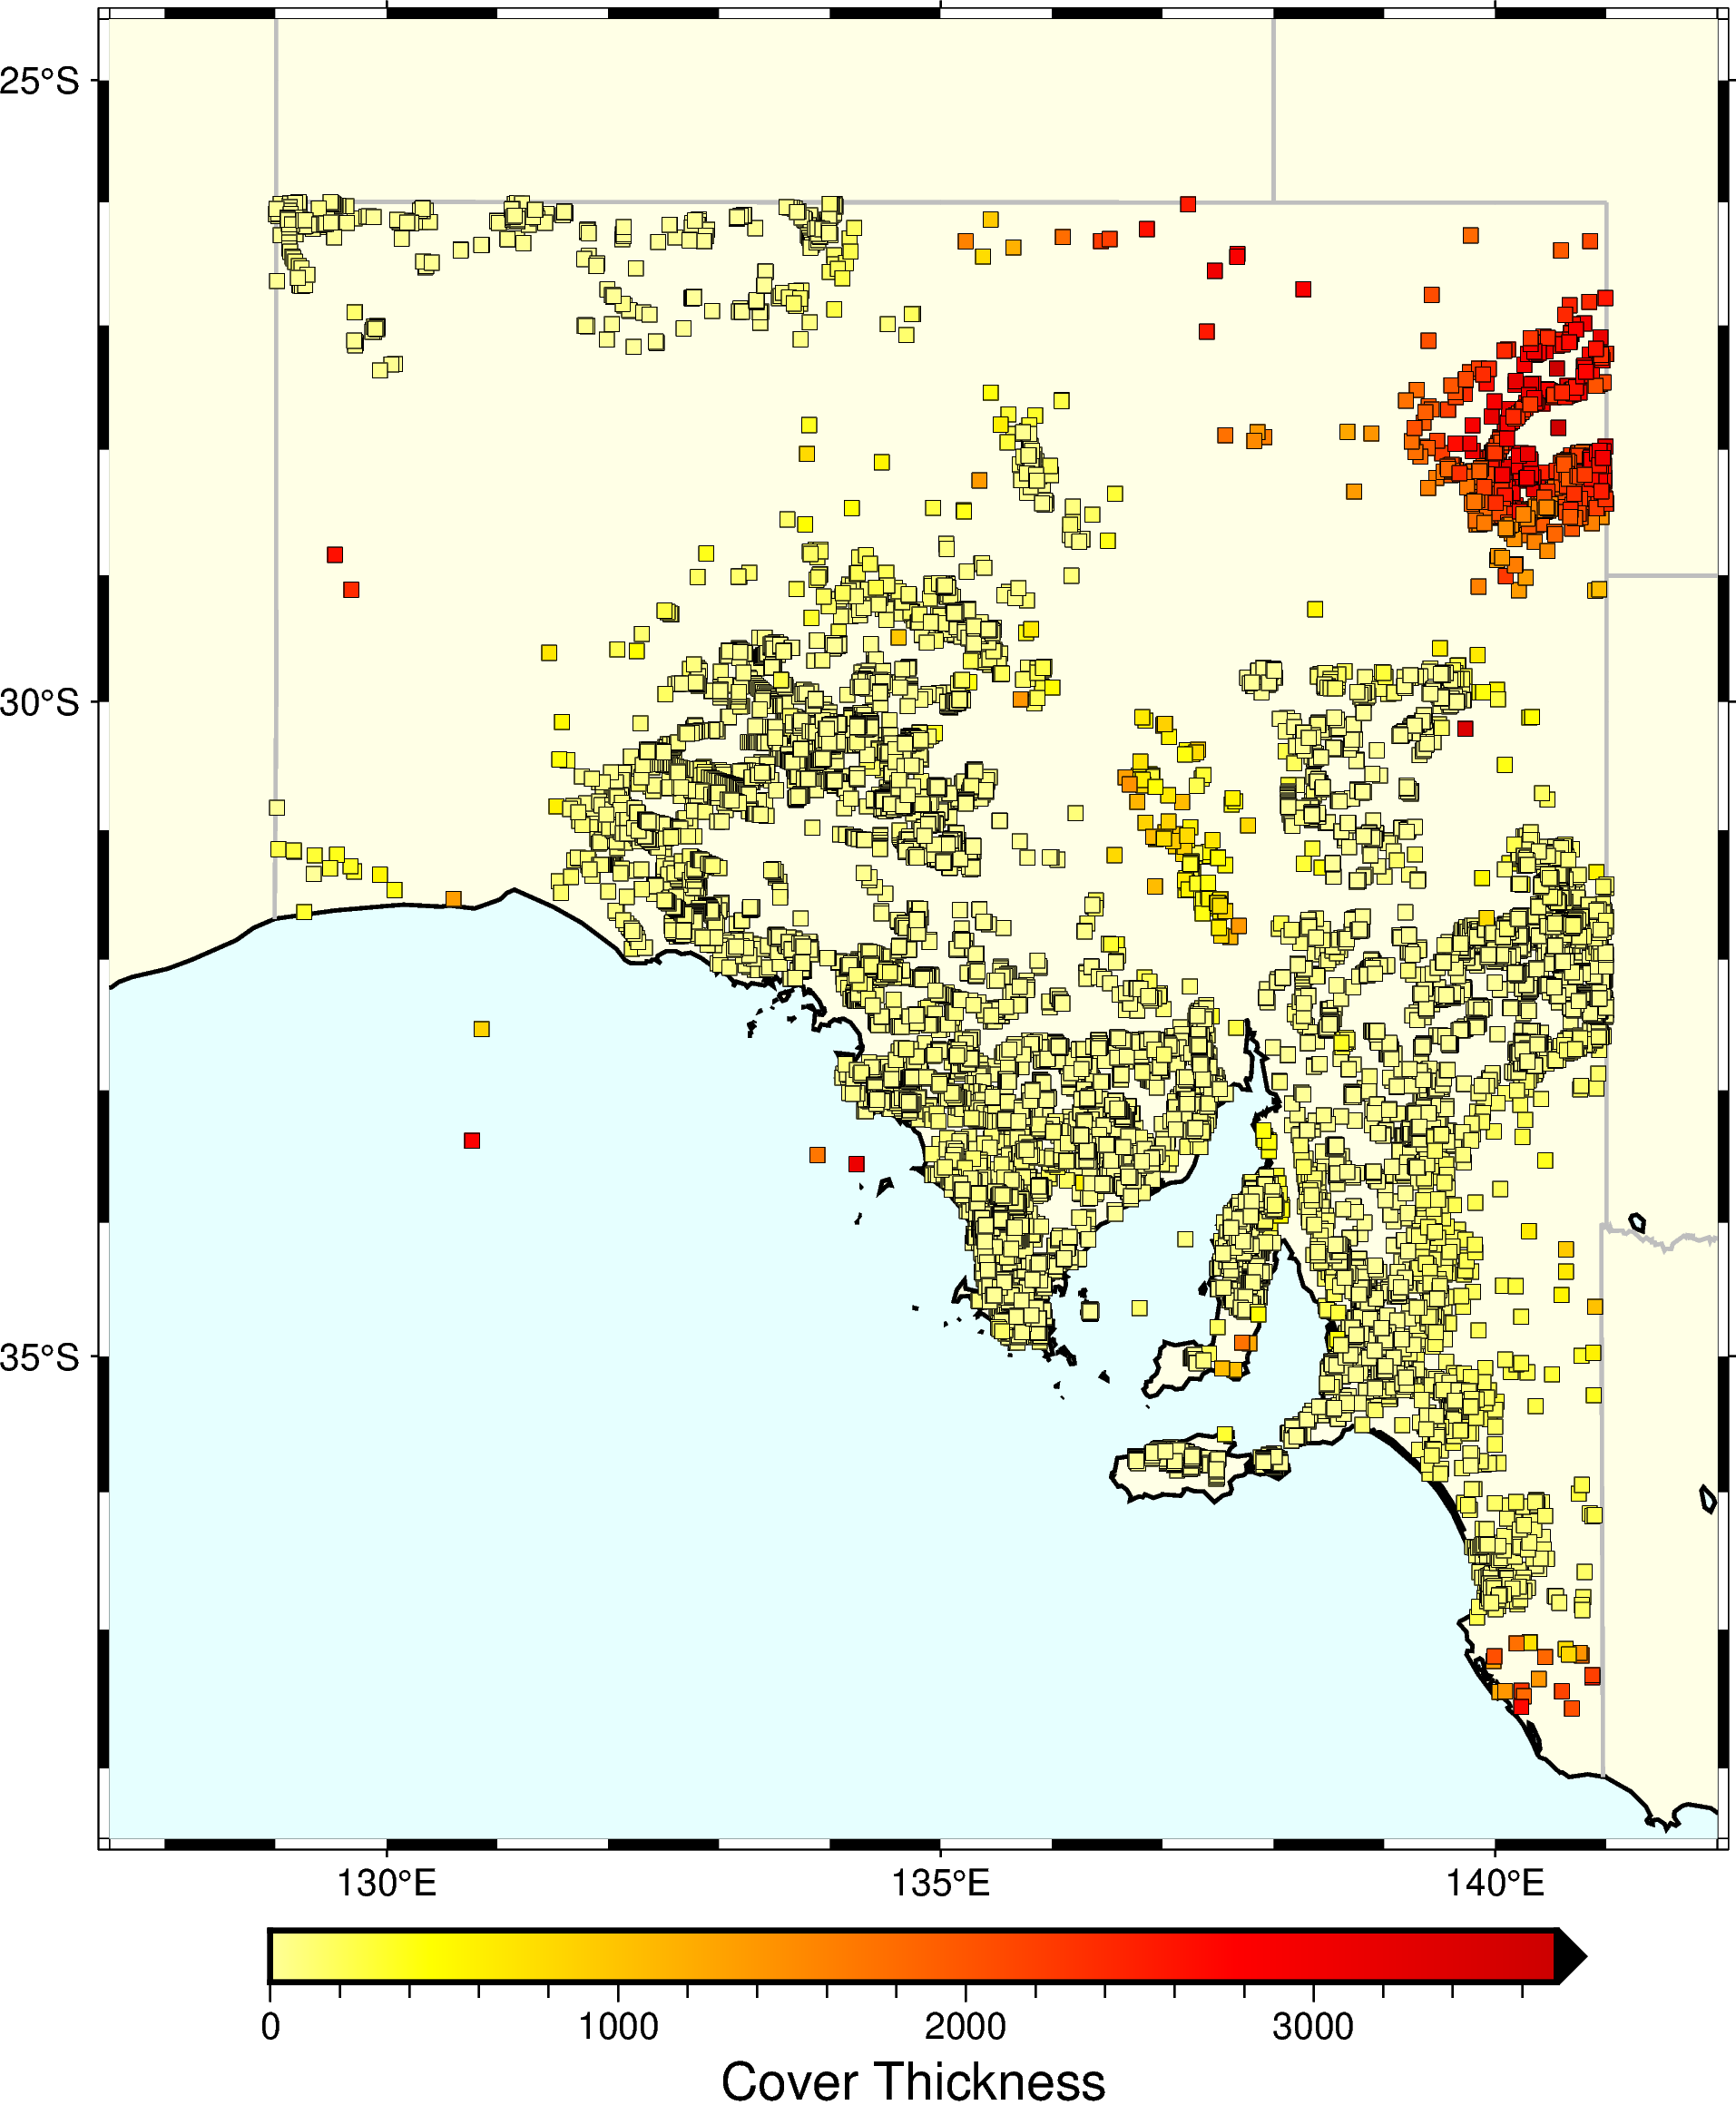

In [87]:
fig = pygmt.Figure()
projection = f"M12/11/15"
ln_min, ln_max = (127.5, 142)
lt_min, lt_max = (-38.5, -24.5)
region = [ln_min, ln_max, lt_min, lt_max]
fig.basemap(region=region, projection=projection)
fig.coast(
    shorelines=1,
    land="#ffffe6",
    water="#e6ffff",
    borders="2/1p,grey",
    projection=projection,
    region=region,
)
pygmt.makecpt(cmap="hot", truncate=[0.3, 0.9], series=[SA.COVR_THICK.min(), SA.COVR_THICK.max()], reverse=True)
x = SA.ADJGDA94_X
y = SA.ADJGDA94_Y
fig.plot(x=x,
         y=y,
         fill=SA.COVR_THICK,
         cmap=True,
         style=f"sc",
         pen="0p",
         size=np.full_like(x, 0.2))
fig.colorbar(
    region=region,
    projection=projection,
    frame=["af+lCover Thickness"],
    position="JBC+ef",
)
fig.show()